In [2]:
from sklearn.datasets import fetch_mldata
import numpy as np

In [3]:
mnist = fetch_mldata('MNIST original')

In [4]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [5]:
X, y = mnist["data"], mnist["target"]

In [6]:
X.shape, y.shape

((70000, 784), (70000,))

In [7]:
%matplotlib inline

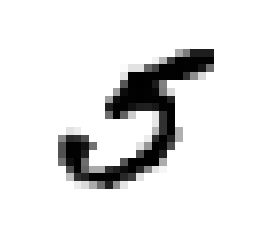

5.0

In [8]:
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap= matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
y[36000]

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5) 

In [10]:
print(len(X_train), len(y_train_5))

60000 60000


In [11]:
from sklearn.linear_model import SGDClassifier

In [12]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [13]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))
    
    

0.9643
0.9597
0.9637


In [15]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)



In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53985,   594],
       [ 1652,  3769]])

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)


0.86385514554205822

In [18]:
recall_score(y_train_5, y_train_pred)

0.69525917727356579

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.77044153720359776

In [20]:
y_scores = sgd_clf.decision_function([some_digit])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [22]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])




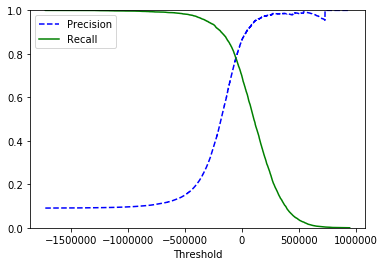

In [23]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()




In [24]:
y_train_pred_90 = (y_scores > 120000)

In [25]:
precision_score(y_train_5, y_train_pred_90)

0.95393258426966288

In [26]:
recall_score(y_train_5, y_train_pred_90)

0.46983951300498061

In [27]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
print(fpr[-1],tpr[-1])

1.0 1.0


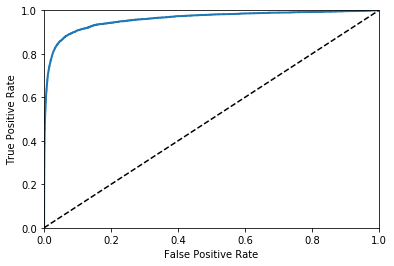

In [28]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()



In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)


0.95974785566521181

In [30]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")


In [31]:
y_scores_forest = y_probas_forest[:, 1]
print(y_scores_forest)

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)



[ 0.   0.   0.  ...,  0.   0.3  0. ]


/Users/jaysurplus/Documents/Github/handon_ml/venv/lib/python3.6/site-packages/matplotlib/legend.py:326: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  six.iterkeys(self.codes))))


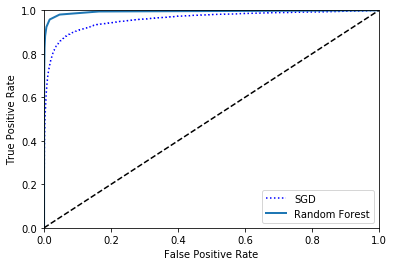

In [32]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()



In [33]:
 roc_auc_score(y_train_5, y_scores_forest)

0.99389483842275594

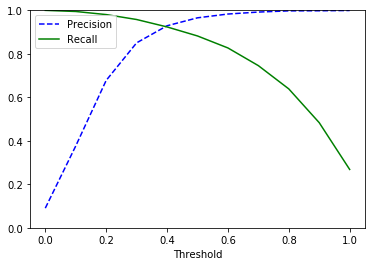

In [34]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores_forest)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
print()

In [35]:
y_preds_forest = list(map(lambda x: x >= 0.5, y_scores_forest))

In [36]:
print("precision",precision_score(y_train_5, y_preds_forest))
print("recall", recall_score(y_train_5, y_preds_forest))

precision 0.965677367252
recall 0.882309536986


### Multiclass Classification

In [37]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [38]:
sgd_clf.predict([some_digit])
some_digit_scores = sgd_clf.decision_function([some_digit])

In [39]:
some_digit_scores

array([[  70405.34944788, -474375.19500257, -482134.04994564,
         -33289.6171971 , -559213.04104327,   66195.48155292,
        -620703.81827745, -505852.33591576, -496907.19431473,
        -464827.30098363]])

In [40]:
np.argmax(some_digit_scores)

0

In [41]:
sgd_clf

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


array([ 0.90881824,  0.91284564,  0.90948642])

In [43]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx




array([[5729,    2,   23,   10,   12,   51,   41,    9,   44,    2],
       [   1, 6471,   49,   23,    6,   42,    4,   13,  121,   12],
       [  50,   34, 5360,   96,   79,   24,   74,   60,  164,   17],
       [  47,   37,  137, 5338,    2,  235,   31,   61,  153,   90],
       [  21,   27,   37,   10, 5367,    9,   50,   27,   89,  205],
       [  65,   45,   39,  179,   77, 4622,  111,   28,  171,   84],
       [  37,   25,   57,    2,   46,   92, 5605,    8,   46,    0],
       [  21,   24,   71,   31,   53,   12,    6, 5824,   19,  204],
       [  52,  141,   70,  143,   15,  162,   53,   30, 5064,  121],
       [  40,   33,   25,   84,  173,   37,    2,  220,   92, 5243]])

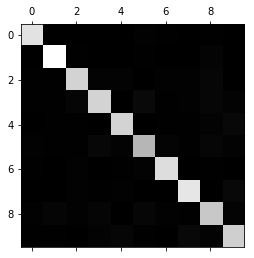

In [44]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [45]:
row_sums = conf_mx.sum(axis=1, keepdims=True)

In [46]:
norm_conf_mx = conf_mx / row_sums

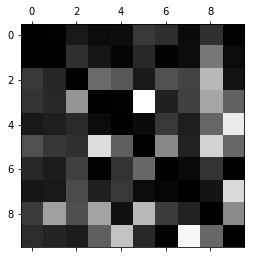

In [47]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()



In [48]:
norm_conf_mx

array([[ 0.        ,  0.00033767,  0.00388317,  0.00168833,  0.002026  ,
         0.0086105 ,  0.00692217,  0.0015195 ,  0.00742867,  0.00033767],
       [ 0.00014832,  0.        ,  0.00726787,  0.00341145,  0.00088994,
         0.00622961,  0.0005933 ,  0.00192821,  0.0179472 ,  0.00177989],
       [ 0.00839208,  0.00570661,  0.        ,  0.01611279,  0.01325948,
         0.0040282 ,  0.01242028,  0.01007049,  0.02752602,  0.00285331],
       [ 0.00766596,  0.0060349 ,  0.02234546,  0.        ,  0.00032621,
         0.0383298 ,  0.00505627,  0.00994944,  0.02495515,  0.0146795 ],
       [ 0.00359466,  0.0046217 ,  0.00633345,  0.00171174,  0.        ,
         0.00154057,  0.00855871,  0.0046217 ,  0.01523451,  0.03509072],
       [ 0.01199041,  0.00830105,  0.00719424,  0.03301974,  0.01420402,
         0.        ,  0.02047593,  0.0051651 ,  0.031544  ,  0.0154953 ],
       [ 0.00625211,  0.0042244 ,  0.00963163,  0.00033795,  0.0077729 ,
         0.01554579,  0.        ,  0.00135181

In [49]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]




NameError: name 'plot_digits' is not defined

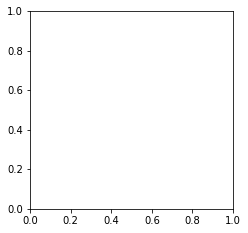

In [50]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()



In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_neighbors': [4000], 'weights': [ 'distance']}]

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()

grid_search = GridSearchCV(knn_clf, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)

grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] n_neighbors=4000, weights=distance ..............................
[CV] n_neighbors=4000, weights=distance ..............................
[CV] n_neighbors=4000, weights=distance ..............................
[CV] n_neighbors=4000, weights=distance ..............................


KeyboardInterrupt: 

In [55]:
knn_clf.predict([some_digit])


array([ 5.])

In [60]:
noise = rnd.randint(0, 100, (len(X_train)), 784)
noise = rnd.randint(0, 100, (len(X_test)), 784)
X_train_mod = X_train + noise
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

NameError: name 'randint' is not defined

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
knn_clf.predict([])

### Exercises

In [67]:
X_train, y_train

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([ 7.,  8.,  4., ...,  7.,  8.,  9.]))